In [ ]:
import pandas as pd
import random, os, numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from lightning.pytorch import LightningDataModule
import torch.nn as nn
from transformers import AutoModel
import torchmetrics
from lightning.pytorch import LightningModule
from pytorch_lightning.loggers import CSVLogger
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
import seaborn as sns
from pathlib import Path
from matplotlib.patches import Patch
from sklearn.metrics import confusion_matrix, classification_report

In [2]:

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed(42)

In [3]:
df = pd.read_csv("D:\Maestria IA\Deep Learning\Proyecto\df_total.csv")
df = df.rename(columns={"news":"text", "Type":"label"})
df = df.dropna(subset=["text","label"])
df["text"] = df["text"].str.strip()
df = df[df["text"].str.len() > 0].drop_duplicates(subset=["text"]).reset_index(drop=True)
df.head()

,url,text,label
0,https://www.larepublica.co/redirect/post/3201905,Durante el foro La banca articulador empresari...,Otra
1,https://www.larepublica.co/redirect/post/3210288,El regulador de valores de China dijo el domin...,Regulaciones
2,https://www.larepublica.co/redirect/post/3240676,En una industria históricamente masculina como...,Alianzas
3,https://www.larepublica.co/redirect/post/3342889,Con el dato de marzo el IPC interanual encaden...,Macroeconomia
4,https://www.larepublica.co/redirect/post/3427208,Ayer en Cartagena se dio inicio a la versión n...,Otra


In [4]:
# train/val/test  (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"])
train_df[["text","label"]].to_csv("train.csv", index=False)
val_df[["text","label"]].to_csv("val.csv", index=False)
test_df[["text","label"]].to_csv("test.csv", index=False)

print("Train:", train_df["label"].value_counts().to_dict())
print("Val:",   val_df["label"].value_counts().to_dict())
print("Test:",  test_df["label"].value_counts().to_dict())

Train: {'Macroeconomia': 255, 'Alianzas': 197, 'Innovacion': 121, 'Regulaciones': 113, 'Otra': 103, 'Sostenibilidad': 99, 'Reputacion': 21}
Val: {'Macroeconomia': 32, 'Alianzas': 24, 'Innovacion': 16, 'Regulaciones': 14, 'Sostenibilidad': 13, 'Otra': 13, 'Reputacion': 2}
Test: {'Macroeconomia': 32, 'Alianzas': 25, 'Innovacion': 15, 'Regulaciones': 14, 'Otra': 13, 'Sostenibilidad': 12, 'Reputacion': 3}


In [6]:
MODEL_CKPT = "dccuchile/bert-base-spanish-wwm-uncased"

In [7]:
class NewsDataset(Dataset):
    def __init__(self, df, label2id, tokenizer, max_length=256):
        self.texts = df["text"].tolist()
        self.labels = [label2id[l] for l in df["label"].tolist()]
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        return {"text": self.texts[idx], "label": self.labels[idx]}

In [8]:
class DynamicCollator:
    def __init__(self, tokenizer, max_length=256):
        self.tok = tokenizer
        self.max_length = max_length
    def __call__(self, batch):
        texts = [b["text"] for b in batch]
        labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)
        toks = self.tok(texts, truncation=True, padding=True, max_length=self.max_length, return_tensors="pt")
        toks["labels"] = labels
        return toks

In [ ]:
#Creamos el mapping label -> id a partir de las clases únicas del df
classes  = sorted(df["label"].astype(str).str.strip().unique().tolist())
label2id = {c: i for i, c in enumerate(classes)}
print("label2id:", label2id)

#Construimos el sample_batch con los 3 primeros registros del df
sample_batch = [
    {"text": row["text"], "label": label2id[row["label"]]}
    for _, row in df.head(100).iterrows()
]
print(sample_batch)

#Probar el DynamicCollator
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
collator  = DynamicCollator(tokenizer, max_length=256)

output = collator(sample_batch)

print(output.keys())              # dict_keys(['input_ids','token_type_ids','attention_mask','labels'])
print(output["input_ids"].shape)  # (3, <=256)
print(output["labels"])           # tensor([...]) con los ids de tus etiquetas

label2id: {'Alianzas': 0, 'Innovacion': 1, 'Macroeconomia': 2, 'Otra': 3, 'Regulaciones': 4, 'Reputacion': 5, 'Sostenibilidad': 6}
[{'text': 'Durante el foro La banca articulador empresarial para el desarrollo sostenible el director de sostenibilidad y clientes globales de BBVA en Colombia Andrés García aseguró que es importante entender que la sostenibilidad no la podemos asociar a mayores costos. Yo creo que el no tener un concepto de negocio sostenible puede tener un mayor impacto de lo que imaginamos.Para García el reto más importante es no cambiar prioridades ni que compitan entre sí necesariamente. En muchos de los casos se debe tratar de mantener la prioridad en cuanto a la ambición de negocios más sostenibles un reto enorme por la coyuntura. La sostenibilidad nos abre oportunidades a mejores fuentes de financiamiento agregó.El directivo argumentó que lo que se encuentra en juego acá no es un tema de rentabilidad o de negocios en particular es un tema de viabilidad del mundo de 

d:\Maestria IA\Entornos\env_torch\venv_torch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
tokenizer

BertTokenizerFast(name_or_path='dccuchile/bert-base-spanish-wwm-uncased', vocab_size=31002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Tokenizando:   0%|          | 0/3 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors


Percentiles (tokens):
  P50: 543
  P75: 793
  P90: 1156
  P95: 1465
  P97: 1687
  P99: 2353
  P100: 3603

Cobertura para max_length propuestos:
  max_length=128  →  cubre   1.8% de los textos
  max_length=256  →  cubre  14.9% de los textos
  max_length=320  →  cubre  23.8% de los textos
  max_length=384  →  cubre  32.5% de los textos
  max_length=512  →  cubre  47.3% de los textos


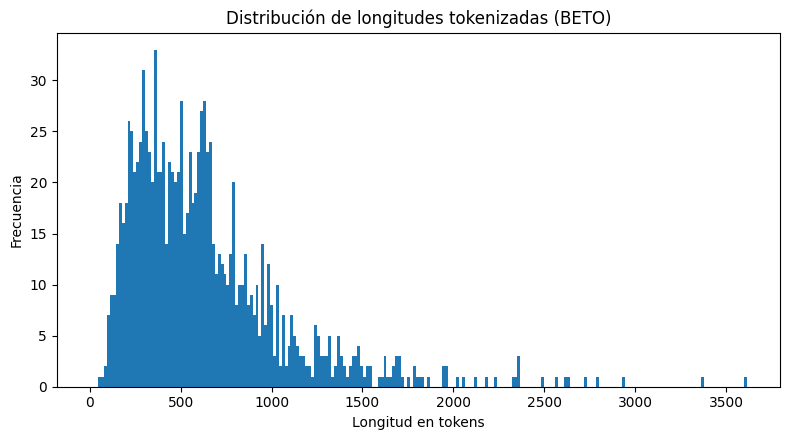

In [ ]:

def compute_token_lengths(df, tokenizer, text_col="text", batch_size=512):
    """
    Devuelve una lista con la longitud (en tokens) de cada texto.
    No usa truncation para ver la longitud 'real' de tokenización.
    """
    texts = df[text_col].fillna("").astype(str).tolist()
    lengths = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizando"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            add_special_tokens=True,
            truncation=False,   # importante para ver la longitud real
        )
        lengths.extend([len(ids) for ids in enc["input_ids"]])

    return np.array(lengths, dtype=np.int32)

def resumen_longitudes(lengths, candidatos_max=(128, 256, 320, 384, 512)):
    """
    Imprime percentiles clave y cobertura para varios max_length.
    """
    pcts = [50, 75, 90, 95, 97, 99, 100]
    vals = np.percentile(lengths, pcts)
    print("Percentiles (tokens):")
    for p, v in zip(pcts, vals):
        print(f"  P{p:>2}: {int(v)}")
    print("\nCobertura para max_length propuestos:")
    n = len(lengths)
    for m in candidatos_max:
        cov = (lengths <= m).sum() / n * 100
        print(f"  max_length={m:>3}  →  cubre {cov:5.1f}% de los textos")

def plot_histograma(lengths, bin_step=16, title="Histograma de longitudes (tokens)"):
    """
    Dibuja un histograma simple
    """
    plt.figure(figsize=(8, 4.5))
    bins = np.arange(0, lengths.max() + bin_step, bin_step)
    plt.hist(lengths, bins=bins)
    plt.xlabel("Longitud en tokens")
    plt.ylabel("Frecuencia")
    plt.title(title)
    plt.tight_layout()
    plt.show()

lengths = compute_token_lengths(df, tokenizer, text_col="text", batch_size=512)
resumen_longitudes(lengths, candidatos_max=(128, 256, 320, 384, 512))
plot_histograma(lengths, bin_step=16, title="Distribución de longitudes tokenizadas (BETO)")


In [16]:
enc = tokenizer([s["text"] for s in sample_batch],
                truncation=True, padding=True, return_tensors="pt")
print([tokenizer.convert_ids_to_tokens(row) for row in enc["input_ids"][25:]])
# O bien:
print(tokenizer.decode(enc["input_ids"][25]))

[['[CLS]', 'la', 'responsable', 'de', 'soluciones', 'para', 'clientes', 'y', 'banca', 'digital', 'de', 'garanti', 'bb', '##va', ',', '[UNK]', 'ak', '##dem', '##ir', '[UNK]', ',', 'repas', '##a', 'los', '15', 'años', 'de', 'la', 'banca', 'móvil', 'y', 'los', 'avances', 'de', 'la', 'sostenibilidad', 'en', 'el', 'mundo', 'financiero', '.', 'los', 'bancos', 'se', 'han', 'considerado', 'siempre', 'como', 'refugio', 'seguro', 'del', 'dinero', ',', 'y', 'tradicional', '##mente', 'el', 'sector', 'bancario', 'crecí', '##a', 'mediante', 'la', 'expansión', 'de', 'su', 'red', 'de', 'sucursal', '##es', 'físicas', '.', 'actualmente', ',', 'en', 'cambio', ',', 'la', 'pandemia', 'ha', 'transformado', 'la', 'banca', 'digital', 'en', 'el', 'canal', 'de', 'preferencia', ',', 'por', 'la', 'facilidad', 'que', 'ofrece', 'para', 'realizar', 'toda', 'clase', 'de', 'operaciones', '.', 'la', 'banca', 'ya', 'es', ',', 'por', 'ello', ',', 'uno', 'de', 'los', 'sectores', 'digitales', 'más', 'potentes', 'del', 'mun

In [ ]:

class NewsDataModule(LightningDataModule):
    def __init__(self, train_path="train.csv", val_path="val.csv", test_path="test.csv",
                 model_ckpt=MODEL_CKPT, max_length=256, batch_size=16):
        super().__init__()
        self.train_path, self.val_path, self.test_path = train_path, val_path, test_path
        self.max_length, self.batch_size = max_length, batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
        self.label2id, self.id2label = None, None

    def setup(self, stage=None):
        tr = pd.read_csv(self.train_path)
        va = pd.read_csv(self.val_path)
        te = pd.read_csv(self.test_path)
        labels = sorted(set(tr["label"]).union(va["label"]).union(te["label"]))
        self.label2id = {l: i for i, l in enumerate(labels)}
        self.id2label = {i: l for l, i in self.label2id.items()}
        self.train_ds = NewsDataset(tr, self.label2id, self.tokenizer, self.max_length)
        self.val_ds   = NewsDataset(va, self.label2id, self.tokenizer, self.max_length)
        self.test_ds  = NewsDataset(te, self.label2id, self.tokenizer, self.max_length)
        self.collator = DynamicCollator(self.tokenizer, self.max_length)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds, batch_size=self.batch_size, shuffle=True,
            collate_fn=self.collator, num_workers=0, pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds, batch_size=self.batch_size*2, shuffle=False,
            collate_fn=self.collator, num_workers=0, pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds, batch_size=self.batch_size*2, shuffle=False,
            collate_fn=self.collator, num_workers=0, pin_memory=True
        )


In [ ]:

class BETO_BiLSTM_LitModule(LightningModule):
    def __init__(self, num_labels, model_ckpt=MODEL_CKPT,
                 lstm_hidden=256, lstm_layers=1, dropout=0.2,
                 lr=2e-5, weight_decay=0.01, encoder_lr=None,
                 class_weights=None):
        super().__init__()
        self.save_hyperparameters()

        # Encoder BETO
        self.encoder = AutoModel.from_pretrained(model_ckpt)
        hidden_size = self.encoder.config.hidden_size  # 768

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0,
            bidirectional=True
        )
        proj_in = lstm_hidden * 2  # BiLSTM

        # Clasificador (mean+max pooling -> concat)
        self.classifier = nn.Sequential(
            nn.Linear(proj_in * 2, proj_in),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(proj_in, num_labels)
        )

        # Pesos de clase como buffer (se mueven con el device)
        if class_weights is not None:
            self.register_buffer("class_weights_buf", torch.tensor(class_weights, dtype=torch.float))
        else:
            self.class_weights_buf = None

        self.criterion = nn.CrossEntropyLoss(weight=self.class_weights_buf)

        # Métricas por etapa (evita mezclar estados)
        self.train_acc = torchmetrics.classification.MulticlassAccuracy(num_classes=num_labels, average="micro")
        self.val_acc   = torchmetrics.classification.MulticlassAccuracy(num_classes=num_labels, average="micro")
        self.test_acc  = torchmetrics.classification.MulticlassAccuracy(num_classes=num_labels, average="micro")

        self.train_f1m = torchmetrics.classification.MulticlassF1Score(num_classes=num_labels, average="macro")
        self.val_f1m   = torchmetrics.classification.MulticlassF1Score(num_classes=num_labels, average="macro")
        self.test_f1m  = torchmetrics.classification.MulticlassF1Score(num_classes=num_labels, average="macro")

    def on_fit_start(self):
        # Re-crear la loss con pesos en el device correcto (si aplica)
        if self.class_weights_buf is not None:
            self.criterion = nn.CrossEntropyLoss(weight=self.class_weights_buf.to(self.device))

    @staticmethod
    def masked_pool(x, mask, mode="mean"):
        # x: (B,T,C), mask: (B,T)
        mask = mask.unsqueeze(-1).type_as(x)  # (B,T,1)
        if mode == "mean":
            s = (x * mask).sum(dim=1)
            d = mask.sum(dim=1).clamp(min=1e-6)
            return s / d
        else:  # "max"
            x_masked = x.masked_fill(mask == 0, float('-inf'))
            return x_masked.max(dim=1).values

    def forward(self, input_ids, attention_mask):
        enc = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        seq = enc.last_hidden_state                      # (B,T,768)
        lstm_out, _ = self.lstm(seq)                     # (B,T,2*lstm_hidden)
        mean_pool = self.masked_pool(lstm_out, attention_mask, "mean")
        max_pool  = self.masked_pool(lstm_out, attention_mask, "max")
        feats = torch.cat([mean_pool, max_pool], dim=-1) # (B, 4*lstm_hidden)
        logits = self.classifier(feats)                  # (B,num_labels)
        return logits

    # ---- pasos compartidos/etapa ------------------------------------------
    def _shared_step(self, batch):
        logits = self(batch["input_ids"], batch["attention_mask"])
        loss = self.criterion(logits, batch["labels"])
        preds = logits.argmax(dim=-1)
        labels = batch["labels"]
        return loss, preds, labels

    def training_step(self, batch, batch_idx):
        loss, preds, labels = self._shared_step(batch)
        acc = self.train_acc(preds, labels)
        f1  = self.train_f1m(preds, labels)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log("train_acc",  acc,  prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log("train_f1_macro", f1, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, labels = self._shared_step(batch)
        acc = self.val_acc(preds, labels)
        f1  = self.val_f1m(preds, labels)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log("val_acc",  acc,  prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log("val_f1_macro", f1, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, preds, labels = self._shared_step(batch)
        acc = self.test_acc(preds, labels)
        f1  = self.test_f1m(preds, labels)

        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log("test_acc",  acc,  prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log("test_f1_macro", f1, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return loss
    # -----------------------------------------------------------------------

    def configure_optimizers(self):
        enc_lr = self.hparams.encoder_lr if self.hparams.encoder_lr is not None else self.hparams.lr
        params = [
            {"params": self.encoder.parameters(), "lr": enc_lr},
            {"params": list(self.lstm.parameters()) + list(self.classifier.parameters()), "lr": self.hparams.lr},
        ]
        optimizer = torch.optim.AdamW(params, weight_decay=self.hparams.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_f1_macro"}

    def freeze_encoder(self, freeze=True):
        for p in self.encoder.parameters():
            p.requires_grad = not freeze


In [ ]:

dm = NewsDataModule(batch_size=32)
dm.setup()

num_labels = len(dm.label2id)
labels_sorted = [dm.id2label[i] for i in range(num_labels)]
print("Etiquetas:", labels_sorted)

Etiquetas: ['Alianzas', 'Innovacion', 'Macroeconomia', 'Otra', 'Regulaciones', 'Reputacion', 'Sostenibilidad']


d:\Maestria IA\Entornos\env_torch\venv_torch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
counts = train_df["label"].value_counts()
class_weights = (1.0 / counts).reindex(labels_sorted).fillna(0).values
class_weights = class_weights * (len(class_weights) / class_weights.sum())  # normaliza
print("Class weights:", class_weights)

Class weights: [0.37986738 0.61846177 0.29346617 0.72654247 0.66224667 3.56351782
 0.75589772]


In [14]:
model = BETO_BiLSTM_LitModule(
    num_labels=num_labels,
    lstm_hidden=256, dropout=0.2,
    lr=1e-3,          # lr para BiLSTM+head
    encoder_lr=1e-5,  # lr del encoder (bajo en etapa B; en A lo congelamos)
    weight_decay=0.01,
    class_weights=class_weights
)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Etapa A: congelar encoder
model.freeze_encoder(True)

ckpt_cb_A = ModelCheckpoint(
    monitor="val_f1_macro",
    mode="max",
    save_top_k=1,
    filename="A-{epoch}-{val_f1_macro:.4f}"
)
es_cb_A = EarlyStopping(monitor="val_f1_macro", mode="max", patience=3)
logger_A = CSVLogger("logs", name="BETO_BiLSTM_A")

trainer_A = Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    precision="16-mixed" if torch.cuda.is_available() else "32-true",
    callbacks=[ckpt_cb_A, es_cb_A, TQDMProgressBar(refresh_rate=1)],
    logger=logger_A,
    log_every_n_steps=1,
    enable_progress_bar=True,
    enable_model_summary=True,   # ← muestra la tabla
    num_sanity_val_steps=0
)

trainer_A.fit(model, datamodule=dm)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 5070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Maestria IA\Entornos\env_torch\venv_torch\Lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | BertModel          | 109 M  | eval 

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [16]:
best_A = None

In [ ]:
[-try:
    ckpt_dir = "logs/BETO_BiLSTM_A"
    # Busca el último "version_*"
    if os.path.isdir(ckpt_dir):
        versions = sorted([d for d in os.listdir(ckpt_dir) if d.startswith("version_")])
        if versions:
            last_ver = versions1]
            ckpts = os.path.join(ckpt_dir, last_ver, "checkpoints")
            if os.path.isdir(ckpts):
                # toma el primero (o el único) .ckpt
                cands = [os.path.join(ckpts, f) for f in os.listdir(ckpts) if f.endswith(".ckpt")]
                if cands:
                    best_A = cands[0]
except Exception as _:
    pass

In [18]:
if best_A:
    print("Cargando mejor checkpoint de A:", best_A)
    model = BETO_BiLSTM_LitModule.load_from_checkpoint(best_A)
else:
    print("No se encontró checkpoint de A; continúo con el modelo en memoria.")

Cargando mejor checkpoint de A: logs/BETO_BiLSTM_A\version_9\checkpoints\A-epoch=8-val_f1_macro=0.8457.ckpt


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Descongela el encoder para afinar todo
model.freeze_encoder(False)

#Baja la LR (encoder y cabeza) para fine-tuning estable
model.hparams.lr = 2e-5          # lr para LSTM + classifier
model.hparams.encoder_lr = 2e-5  # lr para el encoder

#Callbacks de B (monitor a val_f1_macro)
ckpt_cb_B = ModelCheckpoint(
    monitor="val_f1_macro",
    mode="max",
    save_top_k=1,
    filename="B-{epoch}-{val_f1_macro:.4f}"
)
es_cb_B = EarlyStopping(monitor="val_f1_macro", mode="max", patience=3)
logger_B = CSVLogger("logs", name="BETO_BiLSTM_B")

#Trainer (TQDM para VS Code, tabla visible, AMP en GPU)
trainer_B = Trainer(
    max_epochs=4,                     # 3–5 suele bastar en B
    accelerator="gpu",
    devices=1,
    precision="16-mixed" if torch.cuda.is_available() else "32-true",
    callbacks=[ckpt_cb_B, es_cb_B, TQDMProgressBar(refresh_rate=1)],
    logger=logger_B,
    log_every_n_steps=1,
    enable_progress_bar=True,
    enable_model_summary=True,
    num_sanity_val_steps=0
)

#Entrenar Etapa B
trainer_B.fit(model, datamodule=dm)

#Cargar el mejor checkpoint de B (para evaluar y/o exportar)
best_B_path = ckpt_cb_B.best_model_path
print("Best B checkpoint:", best_B_path if best_B_path else "(no guardado)")

if best_B_path:
    model = BETO_BiLSTM_LitModule.load_from_checkpoint(best_B_path)

#Evaluación en test
test_metrics = trainer_B.test(model, datamodule=dm)
print("Test metrics:", test_metrics)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Maestria IA\Entornos\env_torch\venv_torch\Lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | BertModel          | 109 M  | eval 
1 | lstm       | LSTM               | 2.1 M  | train
2 | classifier | Sequential         | 528 K  | train
3 | criterion  | CrossEntropyLoss   | 0      | train
4 | train_acc  | MulticlassAccuracy | 0      | train
5 | val_acc    | MulticlassAccuracy | 0      | train
6 | test_acc   | MulticlassAccuracy | 0      | train
7 | train_f1m  | MulticlassF1Score  | 0      | train
8 |

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


Best B checkpoint: logs\BETO_BiLSTM_B\version_1\checkpoints\B-epoch=3-val_f1_macro=0.9109.ckpt


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Maestria IA\Entornos\env_torch\venv_torch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8771929740905762     │
│       test_f1_macro       │     0.875154972076416     │
│         test_loss         │    0.3549422025680542     │
└───────────────────────────┴───────────────────────────┘

Test metrics: [{'test_loss': 0.3549422025680542, 'test_acc': 0.8771929740905762, 'test_f1_macro': 0.875154972076416}]


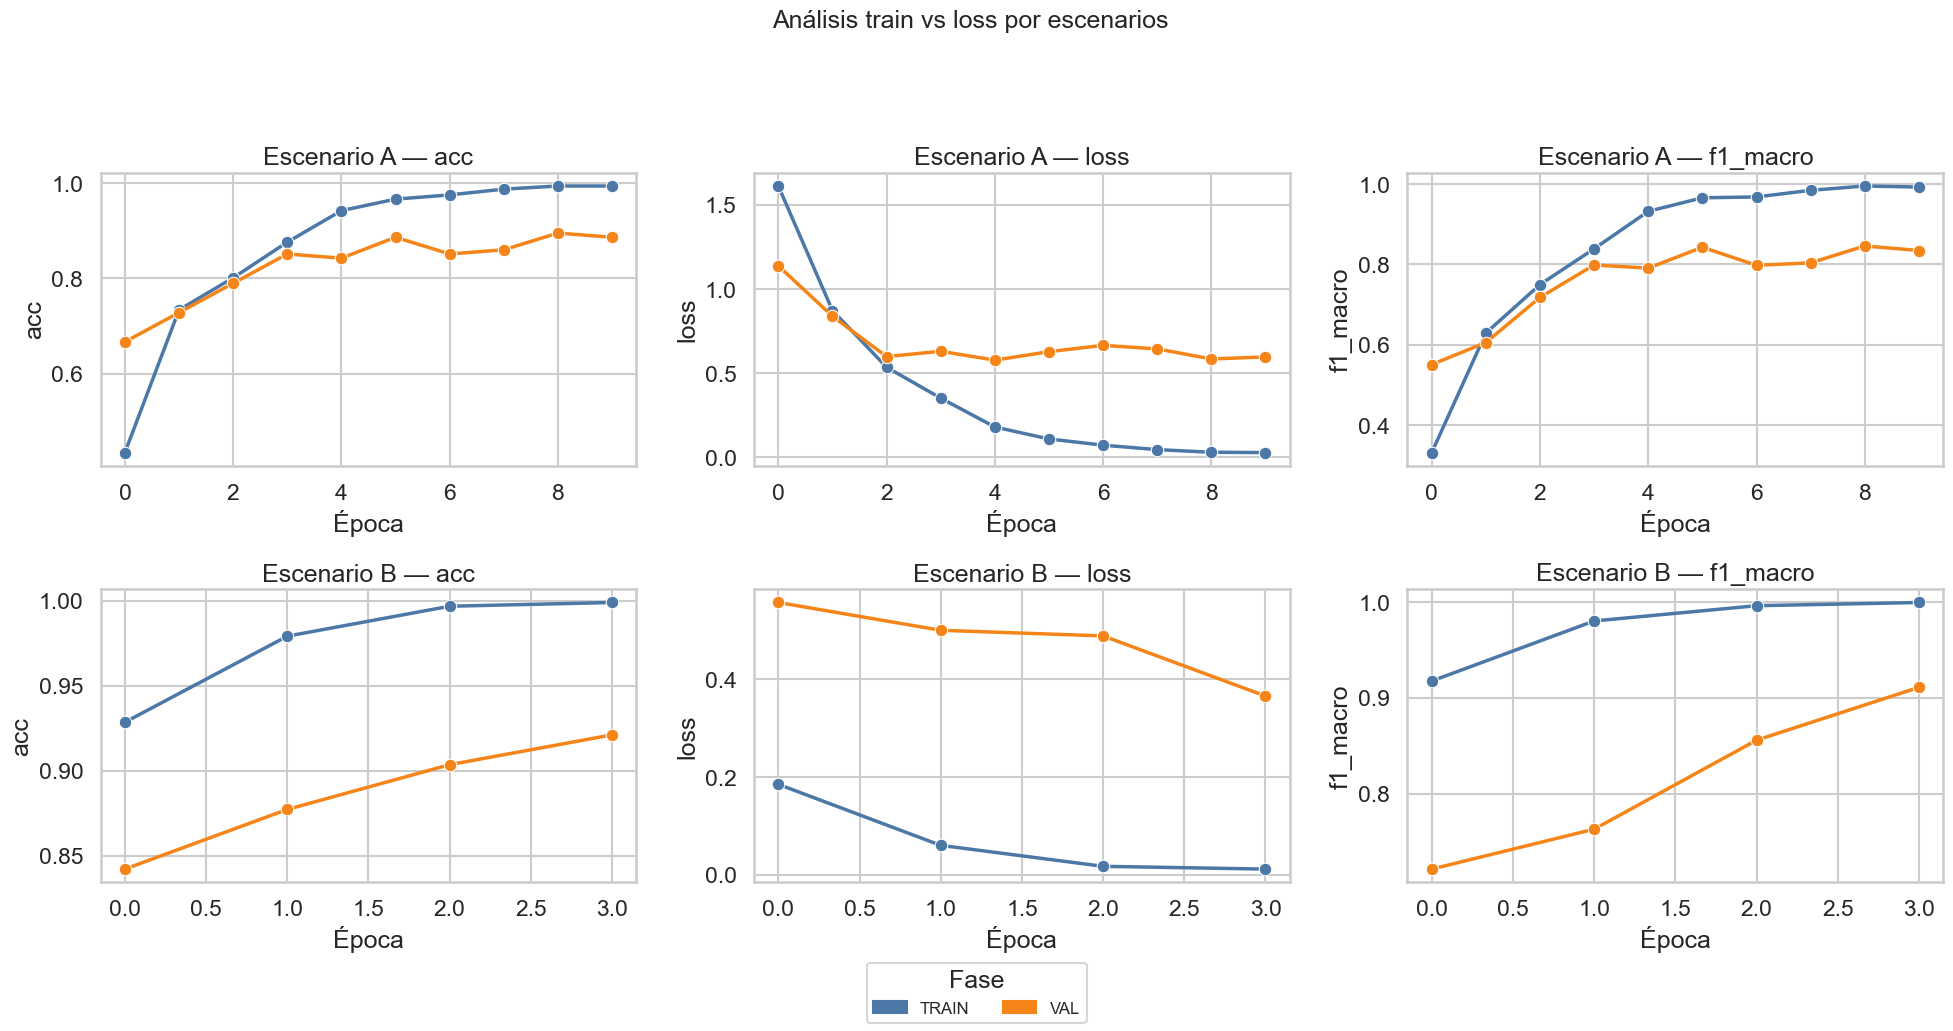

In [ ]:
# -*- coding: utf-8 -*-
# Grid: filas = escenarios (A, B); columnas = métricas (acc, loss, f1_macro)

# ========= CONFIG =========
LOGS_DIR = r"D:\Maestria IA\Deep Learning\logs"
SCENARIOS = {
    "BETO_BiLSTM_A": "version_9",
    "BETO_BiLSTM_B": "version_1",
}
METRICS = ["acc", "loss", "f1_macro"]
PHASES  = ["train", "val"]
PHASE_COLORS = {"train":"#4C78A8", "val": "#F58518"}

sns.set_theme(context="talk", style="whitegrid", font_scale=1.0)
# ==========================

def load_metrics_for_versions(logs_dir: str, selection: dict) -> pd.DataFrame:
    rows = []
    for name, version in selection.items():
        csv_path = Path(logs_dir) / name / version / "metrics.csv"
        if not csv_path.exists():
            raise FileNotFoundError(f"No encuentro {csv_path}")
        df = pd.read_csv(csv_path)

        escenario = "A" if name.lower().endswith("_a") else "B"
        df["escenario"] = escenario
        df["name"] = name
        df["version"] = version

        if "epoch" not in df.columns:
            df["epoch"] = df.groupby(["name", "version"]).cumcount()

        df["_row"] = df.index
        rows.append(df)
    return pd.concat(rows, ignore_index=True)


def build_long_last_per_epoch(df: pd.DataFrame) -> pd.DataFrame:
    value_cols = []
    for ph in PHASES:
        for m in METRICS:
            col = f"{ph}_{m}"
            if col in df.columns:
                value_cols.append(col)

    long_df = df.melt(
        id_vars=["escenario", "name", "version", "epoch", "_row"],
        value_vars=value_cols,
        var_name="phase_metric",
        value_name="value",
    )
    long_df[["phase", "metric"]] = long_df["phase_metric"].str.split("_", n=1, expand=True)
    long_df = long_df.dropna(subset=["value"])

    last = (
        long_df.sort_values("_row")
        .groupby(["escenario", "version", "epoch", "phase", "metric"], as_index=False)
        .tail(1)
    )
    return last.sort_values(["escenario", "epoch", "phase", "metric"])


def plot_grid(df_long: pd.DataFrame):
    escenarios = ["A", "B"]
    n_rows = len(escenarios)
    n_cols = len(METRICS)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols + 2, 5 * n_rows), squeeze=False)

    for r, esc in enumerate(escenarios):
        df_s = df_long[df_long["escenario"] == esc]

        for c, metric in enumerate(METRICS):
            ax = axes[r, c]
            data_m = df_s[df_s["metric"] == metric].sort_values(["epoch"])

            if data_m.empty:
                ax.set_visible(False)
                continue

            
            for ph in PHASES:  # ["train", "val"]
                d = data_m[data_m["phase"] == ph]
                if d.empty:
                    continue
                sns.lineplot(
                    data=d,
                    x="epoch", y="value",
                    linewidth=2.5, marker="o",
                    ax=ax,
                    color=PHASE_COLORS[ph],   # azul para train, naranja para val
                    legend=False
                )

            ax.set_title(f"Escenario {esc} — {metric}")
            ax.set_xlabel("Época")
            ax.set_ylabel(metric)

    # Leyenda global de fases abajo
    from matplotlib.patches import Patch
    phase_patches = [Patch(color=PHASE_COLORS[p], label=p.upper()) for p in PHASES]
    fig.legend(handles=phase_patches, loc="lower center", ncol=len(PHASES), fontsize=12, title="Fase")

    plt.suptitle("Análisis train vs loss por escenarios", y=1.02, fontsize=18)
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])
    plt.show()



# ========== USO ==========
df_wide = load_metrics_for_versions(LOGS_DIR, SCENARIOS)
df_long = build_long_last_per_epoch(df_wide)
plot_grid(df_long)


d:\Maestria IA\Entornos\env_torch\venv_torch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


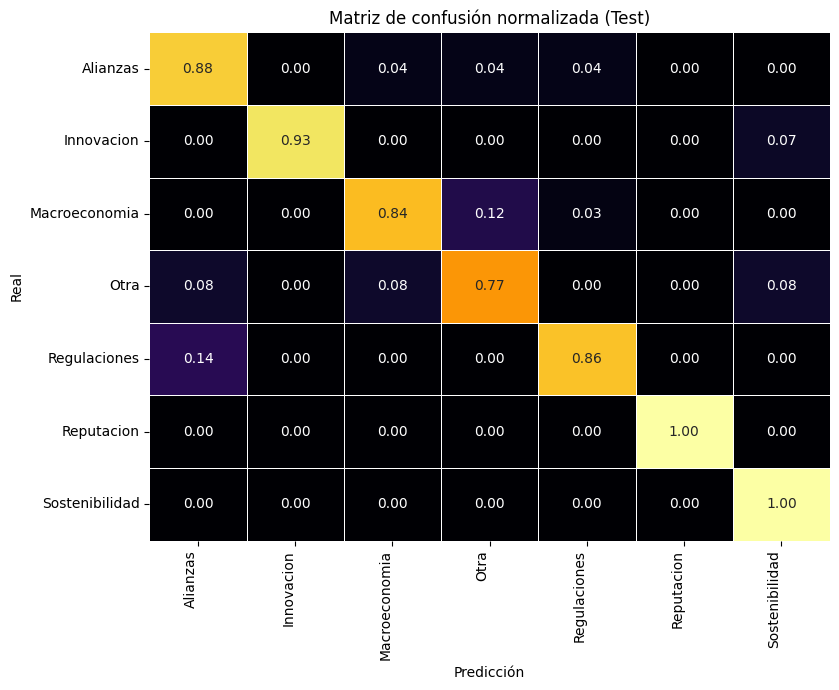

                precision    recall  f1-score   support

      Alianzas       0.88      0.88      0.88        25
    Innovacion       1.00      0.93      0.97        15
 Macroeconomia       0.93      0.84      0.89        32
          Otra       0.67      0.77      0.71        13
  Regulaciones       0.86      0.86      0.86        14
    Reputacion       1.00      1.00      1.00         3
Sostenibilidad       0.86      1.00      0.92        12

      accuracy                           0.88       114
     macro avg       0.88      0.90      0.89       114
  weighted avg       0.88      0.88      0.88       114



In [ ]:

# ========= CONFIG =========
CHECKPOINT_PATH = r"D:\Maestria IA\Deep Learning\logs\BETO_BiLSTM_B\version_1\checkpoints\B-epoch=3-val_f1_macro=0.9109.ckpt"
BATCH_SIZE = 32  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ==========================

#DataModule -> test_dataloader
dm = NewsDataModule(
    train_path="train.csv", val_path="val.csv", test_path="test.csv",
    model_ckpt=MODEL_CKPT, max_length=256, batch_size=BATCH_SIZE
)
dm.setup(stage="test")               # crea test_ds y collator
test_loader = dm.test_dataloader()   # <--- usa el loader del datamodule

#Cargar modelo
model = BETO_BiLSTM_LitModule.load_from_checkpoint(CHECKPOINT_PATH)
model.eval().to(DEVICE)

#Nombres de clases (prioriza los del checkpoint si existen)
CLASS_NAMES = None
try:
    ckpt = torch.load(CHECKPOINT_PATH, map_location="cpu")
    l2i_ckpt = ckpt.get("hyper_parameters", {}).get("label2id", None)
    if l2i_ckpt:
        i2l_ckpt = {v: k for k, v in l2i_ckpt.items()}
        CLASS_NAMES = [i2l_ckpt[i] for i in range(len(i2l_ckpt))]
except Exception:
    pass

if CLASS_NAMES is None:
    # fallback: usa el mapping del datamodule
    CLASS_NAMES = [dm.id2label[i] for i in range(len(dm.id2label))]

num_classes = len(CLASS_NAMES)

#Inferencia en test
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["labels"].to(DEVICE)

        #debe retornar logits al hacer forward
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


#Matriz normalizada por fila (recall por clase)
cm_norm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)), normalize="true")
cmn_df  = pd.DataFrame(cm_norm, index=CLASS_NAMES, columns=CLASS_NAMES)

plt.figure(figsize=(8.5, 7))
sns.heatmap(cmn_df, annot=True, fmt=".2f", cmap="inferno", cbar=False,
            linewidths=0.5, linecolor="white", vmin=0, vmax=1)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión normalizada (Test)")
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#Reporte por clase
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))


In [24]:
id2label = {i: CLASS_NAMES[i] for i in range(len(CLASS_NAMES))}

In [ ]:
df_test = pd.read_csv(r"D:\Maestria IA\Deep Learning\test.csv") 


classes  = sorted(df_test["label"].astype(str).str.strip().unique().tolist())
label2id = {c: i for i, c in enumerate(classes)}

k = random.randrange(len(df_test))   # índice aleatorio
row = df_test.iloc[k]

texto = str(row["text"])             
true_label = str(row["label"])
true_id = label2id.get(true_label, None)  

print(f"idx={k} | label={true_label}" + (f" (id={true_id})" if true_id is not None else ""))
print("texto:\n", texto[:600])       


idx=17 | label=Reputacion (id=5)
texto:
 Merco presentó su más reciente ranking de empresas líderes en Colombia a partir de evaluaciones con 24 fuentes de información y 83.939 encuestas. Los directivos eligieron las 800 empresas más importantes entre 1.944 que tuvieron la participación posteriormente se realizó un filtro de las 100 empresas más importantes.Entre las empresas que conformaron el top 10 Bancolombia mantiene el primer puesto seguida de Ecopetrol que subió tres posiciones del quinto al segundo puesto. El Grupo Nutresa por su parte ocupó el tercer lugar bajando una posición Alpina descendió una posición y ocupó el puesto c


In [34]:

# Tokenizar (256 tokens máx)
enc = tokenizer(
    texto, truncation=True, padding="max_length", max_length=256, return_tensors="pt"
)

# Sólo lo necesario para tu LightningModule (input_ids, attention_mask)
inputs = {
    "input_ids": enc["input_ids"].to(next(model.parameters()).device),
    "attention_mask": enc["attention_mask"].to(next(model.parameters()).device),
}

# Forward e inferencia
with torch.no_grad():
    out = model(**inputs)
    logits = out if isinstance(out, torch.Tensor) else out["logits"]  # por si tu forward retorna dict
    probs = torch.softmax(logits, dim=-1).squeeze(0)

pred_id = int(probs.argmax())
pred_label = id2label[pred_id]
print(f"Predicción: {pred_label} (prob={probs[pred_id]:.3f})")


Predicción: Reputacion (prob=0.994)
